In [66]:
# import necessary packaages
import numpy as np
import pandas as pd
import geopandas as gpd

import requests
import geojson
import json
import urllib

import geoplot
import geoplot.crs as gcrs
import folium
import contextily as cx

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn import cluster
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram

In [20]:
# define functions
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.map(trim_strings)

def read_clean_data(file_name):
    """
    Imports datasets that have semicolon separators for some reason and also weird characters
    """
    df = pd.read_csv(file_name, sep = ';', on_bad_lines='warn')
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.replace('\ufeff', '')
    df = trim_all_columns(df)
    return df

def read_data_api(data_id):
    response = requests.get(str("https://opendata.comune.bologna.it/api/explore/v2.1/catalog/datasets/" + data_id + "/records"))
    df = pd.DataFrame(json.loads(response.content)['results'])
    return df

def read_data_link(url, type):
    """ reads data from a download link copied from Bologna open data website """
    # request the url content
    r = requests.get(url)

    # process the data depending on the file format
    if type == "geojson":
        open('data.geojson', 'wb').write(r.content)
        df = gpd.read_file("data.geojson")
    elif type == "csv":
        open('data.csv', 'wb').write(r.content)
        df = read_clean_data("data.csv")
    # return the output
    return df

def create_map(base_df, analysis_df, base_unit, analysis_unit, geo_frame, quotient = 1):
    """
    Creates a chloropleth map given a base map at neighborhood level (i.e. households or population) 
    and geographic analysis dataset at sub-neighborhood level (points, lines, or polygons)
    """
    # create a base map at the neighborhood level
    base = base_df.reset_index().dissolve('cod_zona')
    # add the points of analysis to the neighborhood base map
    base_w_analysis = base.join(analysis_df)
    # aggregate the points of analysis per the base unit
    base_w_analysis[str(analysis_unit + "_per_" + str(quotient) + "_" + base_unit)] = base_w_analysis[str(analysis_unit + "_count")]/(base_w_analysis['population'] / quotient)
    # round the result to 4 decimal places
    base_w_analysis = base_w_analysis.round(4)
    # create an interactive chlorpleth of this data
    chloropleth = base_w_analysis.explore(column = str(analysis_unit + "_per_" + str(quotient) + "_" + base_unit), cmap = 'RdBu_r', tooltip = ('zona', 'population', str(analysis_unit + "_count"), str(analysis_unit + "_per_" + str(quotient) + "_" + base_unit)), 
                                          tiles = 'CartoDB positron', legend=True)
    # call explore function
    return geo_frame.explore(m = chloropleth)

def create_geo_df(df):
    """
    Takes a df of a certain format and transforms it into a geopandas compatible data frame
    """
    df[['y','x']] = df['Geo Point'].str.split(', ', expand = True)
    df_geo = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y), crs="EPSG:4326")
    return df_geo

def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()
    if not max_weight:
        max_weight = 2**np.ceil(np.log(np.abs(matrix).max())/np.log(2))
    ax.patch.set_facecolor('lightgray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    for (x, y), w in np.ndenumerate(matrix):
        color = 'red' if w > 0 else 'blue'
        size = np.sqrt(np.abs(w))
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
        facecolor=color, edgecolor=color)
        ax.add_patch(rect)
    nticks = matrix.shape[0]
    ax.xaxis.tick_top()
    ax.set_xticks(range(nticks))
    ax.set_xticklabels(list(matrix.columns), rotation=90)
    ax.set_yticks(range(nticks))
    ax.set_yticklabels(matrix.columns)
    ax.grid(False)
    ax.autoscale_view()
    ax.invert_yaxis()

def screeplot(pca, standardised_values):
    """ Creates a plot that shows results of principal components in descending order by variation """
    y = np.std(pca.transform(standardised_values), axis=0)**2
    x = np.arange(len(y)) + 1
    plt.plot(x, y, "o-")
    plt.xticks(x, ["Comp."+str(i) for i in x], rotation=60)
    plt.ylabel("Variance")
    plt.show()

def pca_summary(pca, standardised_data, out=True):
    """ Outputs summary statistics for principal components """
    names = ["PC"+str(i) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    a = list(np.std(pca.transform(standardised_data), axis=0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_)+1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(list(zip(a, b, c)), index=names, columns=columns)
    if out:
        print("Importance of components:")
        display(summary)
    return summary

def pca_scatter(pca, standardised_values, classifs):
    """ Creates a scatter plot of clusters of the principal components analysis given data and a number of classification groups """
    foo = pca.transform(standardised_values)
    bar = pd.DataFrame(list(zip(foo[:, 0], foo[:, 1], classifs)), columns=["PC1", "PC2", "Class"])
    sns.lmplot(x = "PC1", y = "PC2", data = bar, hue="Class", fit_reg=False)

In [21]:
# import base data sets

    # import geojson of base map of statistical areas
base_map_data = read_data_link("https://opendata.comune.bologna.it/api/explore/v2.1/catalog/datasets/aree-statistiche/exports/geojson?lang=it&timezone=Europe%2FRome","geojson")

# convert CRS to equal area
base_map_data = base_map_data.to_crs(epsg=6933)
# rename zones for consistency
base_map_data.loc[base_map_data.zona == 'S. Viola', 'zona'] = 'Santa Viola'
base_map_data.loc[base_map_data.zona == 'S. Vitale', 'zona'] = 'San Vitale'
base_map_data.loc[base_map_data.zona == 'S. Ruffillo', 'zona'] = 'San Ruffillo'
# create a map at the zone level
base_map_zone = base_map_data.dissolve('zona')[['geometry','cod_zona']]

#read_data_link("")

    # import population data
#population = read_clean_data("./Data/popolazione-residente-per-eta-sesso-cittadinanza-quartiere-zona-area-statistica-.csv")
population = read_data_link("https://opendata.comune.bologna.it/api/explore/v2.1/catalog/datasets/popolazione-residente-per-eta-sesso-cittadinanza-quartiere-zona-area-statistica-/exports/csv?lang=it&timezone=Europe%2FRome&use_labels=true&delimiter=%3B", 'csv')
# cast the year column as a string for future processing
population['Anno'] = population['Anno'].astype(str)
    # clean and combine the dataset with the base map
# aggregate population at the zone level
pop_agg = population.groupby(['Anno', 'Zona'])['Residenti'].sum().to_frame().pivot_table('Residenti', ['Zona'], 'Anno')
# get 2019 data
pop_2019 = pop_agg[['2019']].rename(columns={'2019':'population'})
# join the base map data with the population data
base_map_2019 = base_map_zone.join(pop_2019)

    # import household data
# number of resident households / families per neighborhood
#households = read_clean_data("./Data/famiglie-residenti-per-quartiere-zona-area-statistica-e-ampiezza-della-famiglia-.csv")
households = read_data_link("https://opendata.comune.bologna.it/api/explore/v2.1/catalog/datasets/famiglie-residenti-per-quartiere-zona-area-statistica-e-ampiezza-della-famiglia-/exports/csv?lang=it&timezone=Europe%2FRome&use_labels=true&delimiter=%3B", 'csv')
# cast the year column as a string for future processing
households['Anno'] = households['Anno'].astype(str)
    # clean and combine the dataset with the base map
# aggregate the household count at the zone level
households_agg = households.groupby(['Anno', 'Zona'])['Numero Famiglie'].sum().to_frame().pivot_table('Numero Famiglie', ['Zona'], 'Anno')
# get 2019 data
hh_2019 = households_agg[['2019']].rename(columns={'2019':'households'})
# create a base map with number of households to explore in comparison to per capita
base_map_2019 = base_map_2019.join(hh_2019)

    # import income data
#income = read_clean_data("./Data/redditi-per-area-statistica.csv")
income = read_data_link("https://opendata.comune.bologna.it/api/explore/v2.1/catalog/datasets/redditi-per-area-statistica/exports/csv?lang=it&timezone=Europe%2FRome&use_labels=true&delimiter=%3B", 'csv')
# format the year field
income['Anno reddito'] = income['Anno reddito'].astype(str)
income = income.rename(columns={'Anno reddito':'anno'})
# pivot the income to have each year be a column
#income = income.pivot_table(values = ['Reddito medio contribuente','N contribuenti'], index = ['Area Statistica'], columns = ['anno'])
# get most recent data
income_2019 = income.loc[income['anno'] == '2019']
# join with zones and aggregate at zone level
# value needs to be capitalized for matching 
income_2019['Area Statistica'] = income_2019['Area Statistica'].str.upper()
# rename and filter to relevant columns
income_2019 = income_2019.rename(columns={'Area Statistica':'area_statistica','N contribuenti':'n_taxpayers','Reddito imponibile ai fini irpef':'total_income'})[['area_statistica','n_taxpayers','total_income']]
# aggregate at the statistical area level
income_2019_agg = income_2019.groupby(['area_statistica'])[['n_taxpayers','total_income']].sum()
# join the base map data and aggregate income data at the zone level 
income_zone = income_2019_agg.join(base_map_data.reset_index().set_index('area_statistica')).groupby(['zona'])[['n_taxpayers','total_income']].sum()
income_zone['avg_income'] = round(income_zone['total_income'] / income_zone['n_taxpayers'],0)
# append income info to 2019 base map
base_map_2019 = base_map_2019.join(income_zone[['n_taxpayers','avg_income']])
# calculate taxpayers per capita
base_map_2019['taxpayers_per_cap'] = round(base_map_2019['n_taxpayers'] / base_map_2019['population'],4)
    
    # import employment and student data
#occupation = read_clean_data("./Data/occupati_statistica.csv")
occupation = read_data_link("https://opendata.comune.bologna.it/api/explore/v2.1/catalog/datasets/occupati_statistica/exports/csv?lang=it&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B", 'csv')
# format the year field
occupation['Anno di riferimento'] = occupation['Anno di riferimento'].astype(str)
occupation = occupation.rename(columns={'Anno di riferimento':'anno', 'Nome zona':'zona','Sezione censimento (2011)':'census_tract','Numero unità locali':'n_local_units','Numero addetti (dipendenti e indipendenti)':'n_workers','Numero addetti istituzioni pubbliche':'n_public_workers','Numero studenti':'n_students'})
# format the zona field
occupation.loc[occupation.zona == 'S. Viola', 'zona'] = 'Santa Viola'
occupation.loc[occupation.zona == 'S. Vitale', 'zona'] = 'San Vitale'
occupation.loc[occupation.zona == 'S. Ruffillo', 'zona'] = 'San Ruffillo'
# get only the latest data
occupation_2019 = occupation.loc[occupation['anno'] == '2019']
# aggregate the stats at the zona level
occupation_2019_agg = occupation_2019.groupby(['zona'])[['n_workers','n_students']].sum()
# append occupation info to the base map
base_map_2019 = base_map_2019.join(occupation_2019_agg) # *** number of workers seems a bit off - ask marco about it
# calculate workers and students per capita
base_map_2019['workers_per_cap'] = round(base_map_2019['n_workers'] / base_map_2019['population'],4)
base_map_2019['students_per_cap'] = round(base_map_2019['n_students'] / base_map_2019['population'],4)

    # calculate additional socioeconomic stats
# density
base_map_2019['pop_density_km2'] = round(base_map_2019['population'] / (base_map_2019.area/1000000), 0)
# avg people per household
base_map_2019['avg_household_size'] = round(base_map_2019['population'] / base_map_2019['households'], 2)

# scratchpad to view data
base_map_2019

/var/folders/h0/v7zgqxss2wd19s_7gjwcb35r0000gn/T/ipykernel_72198/4289841232.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_2019['Area Statistica'] = income_2019['Area Statistica'].str.upper()


geometry cod_zona  \
zona                                                                          
Barca            POLYGON ((1090863.898 5134599.020, 1090897.505...        A   
Bolognina        POLYGON ((1095745.882 5135403.240, 1095738.186...        B   
Borgo Panigale   POLYGON ((1089322.227 5134968.873, 1089311.237...        C   
Colli            POLYGON ((1095313.116 5132678.853, 1095330.743...        D   
Corticella       POLYGON ((1095936.171 5136829.319, 1095934.779...        E   
Costa Saragozza  POLYGON ((1092211.245 5132467.049, 1092206.791...        F   
Galvani          POLYGON ((1095316.775 5133775.949, 1095379.646...        G   
Irnerio          POLYGON ((1095248.043 5133799.724, 1095224.424...        H   
Lame             POLYGON ((1093948.003 5136890.582, 1093943.073...        I   
Malpighi         POLYGON ((1094320.882 5133697.008, 1094311.370...        L   
Marconi          POLYGON ((1094502.233 5134360.132, 1094478.095...        M   
Mazzini          POLYGON ((1099555.583 5131464.123, 1099598.650...        N   
Murri            POLYGON ((1097674.583 5132304.411, 1097675.047...        O   
Saffi            POLYGON ((1092881.434 5134435.320, 1092881.049...        P   
San Donato       POLYGON ((1097569.457 5134586.171, 1097558.967...        Q   
San Ruffillo     POLYGON ((1097303.980 5130125.817, 1097304.883...        R   
San Vitale       POLYGON ((1101474.382 5133009.811, 1101459.299...        T   
Santa Viola      POLYGON ((1091186.599 5135000.488, 1091161.180...        S   

                 population  households  n_taxpayers  avg_income  \
zona                                                               
Barca               21097.0     10478.0        15838     22480.0   
Bolognina           36388.0     19343.0        25915     21062.0   
Borgo Panigale      26764.0     13301.0        19850     22023.0   
Colli                8836.0      4198.0         5901     46052.0   
Corticella          18594.0      8982.0        13917     23347.0   
Costa Saragozza     24757.0     13492.0        18596     31058.0   
Galvani             13109.0      7605.0         9482     39098.0   
Irnerio             13751.0      8704.0        10090     33093.0   
Lame                14543.0      7176.0        10687     22188.0   
Malpighi            11941.0      7177.0         8870     31953.0   
Marconi             14658.0      8820.0        11097     32556.0   
Mazzini             38571.0     19873.0        29303     24233.0   
Murri               28814.0     15422.0        21409     32750.0   
Saffi               18239.0     10333.0        13814     24210.0   
San Donato          31527.0     16632.0        22798     20666.0   
San Ruffillo        21571.0     11047.0        16124     25950.0   
San Vitale          34793.0     19011.0        25380     24913.0   
Santa Viola         13498.0      7101.0         9844     23785.0   

                 taxpayers_per_cap  n_workers  n_students  workers_per_cap  \
zona                                                                         
Barca                       0.7507       5055      3160.0           0.2396   
Bolognina                   0.7122      11247      7424.0           0.3091   
Borgo Panigale              0.7417      14442      2260.0           0.5396   
Colli                       0.6678       2490       658.0           0.2818   
Corticella                  0.7485      10077      2083.0           0.5419   
Costa Saragozza             0.7511       4468      1891.0           0.1805   
Galvani                     0.7233       9502      3244.0           0.7248   
Irnerio                     0.7338      11894      1470.0           0.8650   
Lame                        0.7349       7795      2319.0           0.5360   
Malpighi                    0.7428       7732      6258.0           0.6475   
Marconi                     0.7571      14658      2734.0           1.0000   
Mazzini                     0.7597       5567      4333.0           0.1443   
Murri                   

In [22]:
# HOUSEHOLD SIZE

# map the household size
base_map_2019.explore(column = 'avg_household_size', cmap = 'RdBu_r', tooltip = ('zona', 'population', 'households', 'avg_household_size'), 
                                          tiles = 'CartoDB positron', legend=True)

In [25]:
# HOUSEHOLD SECURITY #

# 1. airbnb #

    # import airbnb data
# number of airbnbs from airbnb survey
#airbnb = pd.read_csv("./Data/bologna-rilevazione-airbnb.csv", on_bad_lines='warn')
airbnb = read_data_link("https://opendata.comune.bologna.it/api/explore/v2.1/catalog/datasets/bologna-rilevazione-airbnb/exports/geojson?lang=it&timezone=Europe%2FBerlin", 'geojson')
airbnb = airbnb.to_crs(epsg=6933)

    # process the data set in prepartion for mapping
# aggregate the count of wifi hotspots at the neighborhood level
airbnb_agg = gpd.overlay(base_map_2019, airbnb, how='intersection', keep_geom_type=False).groupby('cod_zona').count()
# rename and subset the data just to the count of the hotspots per neighborhood
airbnb_agg = airbnb_agg.rename(columns={'id':'airbnb_count'})['airbnb_count'].to_frame()

create_map(base_map_2019, airbnb_agg, 'household', 'airbnb', airbnb)

In [90]:
# WIFI #

    # import wifi data
#connections = read_clean_data("./Data/bolognawifi-connessioni-giornaliere.csv")
#connections = read_data_link("https://opendata.comune.bologna.it/api/explore/v2.1/catalog/datasets/bolognawifi-connessioni-giornaliere/exports/csv?lang=it&timezone=Europe%2FRome&use_labels=true&delimiter=%3B", 'csv')
wifi = read_data_link("https://opendata.comune.bologna.it/api/explore/v2.1/catalog/datasets/bolognawifi-elenco-hot-spot/exports/geojson?lang=it&timezone=Europe%2FRome", 'geojson')
wifi = wifi.to_crs(epsg=6933)

    # process the data for mapping
# turn the wifi data into a geo data frame
#wifi_geo = gpd.GeoDataFrame(
#    wifi, geometry=gpd.points_from_xy(wifi.x, wifi.y), crs="EPSG:4326"
#)
# aggregate the count of wifi hotspots at the neighborhood level
wifi_agg = gpd.overlay(base_map_2019, wifi, how='intersection', keep_geom_type=False).groupby('cod_zona').count()
# rename and subset the data just to the count of the hotspots per neighborhood
#wifi_agg = wifi_agg.rename(columns={'hostname':'hotspot_count'})['hotspot_count']
wifi
# map the wifi per capita
#create_map(base_map_2019, wifi_agg, 'population', 'hotspot', wifi, quotient = 1000)

description                         hostname          x  \
0           Arboreto del Pilastro             ap-lepida-arboreto-1  11.387130   
1            Piazza San Francesco           ap-lepida-sfrancesco-1  11.334880   
2             P.zza Unità  zona 1                ap-lepida-unita-1  11.347190   
3                    Piazza Verdi                ap-lepida-verdi-1  11.350524   
4                    Piazza Verdi                ap-lepida-verdi-2  11.350856   
..                            ...                              ...        ...   
298   Sottopasso - salone indiano                 Salone-indiano-3  11.343430   
299   Sottopasso - salone indiano                 Salone-indiano-4  11.343430   
300                    Sottopasso              Sottopasso-mostra-5  11.343430   
301             velostazione, bar            wifi-velostazione-bar  11.345320   
302  velostazione, corridoio nord  wifi-velostazione-corridoionord  11.345320   

             y          nomeareast        zona_pross attivo  \
0    44.507970            PILASTRO  SAN DONATO NUOVO     Sì   
1    44.495080          MALPIGHI-2          MALPIGHI     Sì   
2    44.511610  PIAZZA DELL'UNITA'         BOLOGNINA     Sì   
3    44.496260           IRNERIO-2           IRNERIO     Sì   
4    44.496375           IRNERIO-2           IRNERIO     Sì   
..         ...                 ...               ...    ...   
298  44.494610           GALVANI-1           GALVANI     Sì   
299  44.494610           GALVANI-1           GALVANI     Sì   
300  44.494610           GALVANI-1           GALVANI     Sì   
301  44.503534           IRNERIO-2           IRNERIO     Sì   
302  44.503534           IRNERIO-2           IRNERIO     Sì   

                            geometry  
0    POINT (1098701.816 5135229.970)  
1    POINT (1093660.408 5134049.364)  
2    POINT (1094848.154 5135563.314)  
3    POINT (1095169.823 5134157.492)  
4    POINT (1095201.914 5134168.007)  
..                               ...  
298  POINT (1094485.366 5134006.312)  
299  POINT (1094485.366 5134006.312)  
300  POINT (1094485.366 5134006.312)  
301  POINT (1094667.758 5134823.703)  
302  POINT (1094667.758 5134823.703)  

[303 rows x 8 columns]

In [93]:
# PARTICIPATORY BUDGET #

    # import civic participation data
#participative_budget = read_clean_data("./Data/bilancio-partecipativo.csv")
budg_geo = read_data_link("https://opendata.comune.bologna.it/api/explore/v2.1/catalog/datasets/bilancio-partecipativo/exports/geojson?lang=it&timezone=Europe%2FRome",'geojson')
#budg_geo.edizionebp

    # process data for mapping
# aggregate the count of participative budget projects at the neighborhood level
# TO DO - resolve mixed geometry situation
#budg_agg = gpd.overlay(base_map_2019, budg_geo, how='intersection', keep_geom_type=False).groupby('cod_zona').count()
#budg_agg
# rename and subset the data just to the count of the projects per neighborhood
#budg_agg = budg_agg.rename(columns={'Progetto':'project_count'})['project_count']

    # map the data
#create_map(base_map_2019, budg_agg, 'population', 'project', budg_geo, quotient = 1000)

In [96]:
# STREET FURNITURE #

    # import the street furniture dataset
furniture = read_data_link("https://opendata.comune.bologna.it/api/explore/v2.1/catalog/datasets/arredo/exports/geojson?lang=it&timezone=Europe%2FRome",'geojson')
furniture = furniture.to_crs(epsg=6933)
# visually explore street furniture data
#furniture.explore(column = 'classe_conservazione')

# subset columns to relevant columns
furniture = furniture[['classe_arredo','data_agg','geometry','classe_conservazione']]
furniture.data_agg = pd.to_datetime(furniture.data_agg)
# subset data to only those furniture updated before the end of 2019
furniture_2019 = furniture.loc[furniture['data_agg'] <= '2019-12-31']
furniture_2019_zona = gpd.overlay(base_map_2019, furniture_2019, how='intersection', keep_geom_type=False)

# calculate the percentage of not "good" condition street furniture by zone
total_furniture = furniture_2019_zona['cod_zona'].value_counts()
not_good_furniture

cod_zona
Q    1462
C    1207
A     980
N     976
E     907
O     827
B     638
I     631
T     593
R     585
S     508
F     508
P     232
M     220
H     215
G     180
D     160
L     150
Name: count, dtype: int64

In [52]:
# TRANSPORT SECURITY #
# create a dataset of transport related metrics for 2019 to correlate with each other as well as other base statistics

    # bike lanes
#bike_lanes = gpd.read_file("./Data/piste-ciclopedonali.geojson")
bike_lanes = read_data_link("https://opendata.comune.bologna.it/api/explore/v2.1/catalog/datasets/piste-ciclopedonali/exports/geojson?lang=it&timezone=Europe%2FRome", "geojson")
bike_lanes
# *** NOT AVAILABLE FOR 2019 ? ***

codice                   anno  lunghezza                    duso  \
0        999  Precedente 31/12/2021      255.0               Ciclabile   
1       2019  Precedente 31/12/2021       61.0      Pedonale-Ciclabile   
2        568  Precedente 31/12/2021      411.0               Ciclabile   
3       1784  Precedente 31/12/2021      142.0               Ciclabile   
4       2009  Precedente 31/12/2021       72.0  Percorso naturalistico   
...      ...                    ...        ...                     ...   
1792    2282  Precedente 31/12/2021      112.0      Pedonale-Ciclabile   
1793    2147  Precedente 31/12/2021       52.0      Pedonale-Ciclabile   
1794    2159  Precedente 31/12/2021      104.0               Ciclabile   
1795    2024  Precedente 31/12/2021      190.0      Pedonale-Ciclabile   
1796    1323  Precedente 31/12/2021      254.0      Pedonale-Ciclabile   

                         dtipologia2                nomequart  \
0                       sede propria                   Savena   
1     ciclabile contigua al pedonale                   Navile   
2                       sede propria            Santo Stefano   
3                       sede propria  San Donato - San Vitale   
4                        pavimentato                   Savena   
...                              ...                      ...   
1792  ciclabile contigua al pedonale                   Navile   
1793  ciclabile contigua al pedonale                   Navile   
1794                    sede propria                   Navile   
1795                    sede propria                   Navile   
1796         promiscuo ciclopedonale                   Savena   

                                           geo_point_2d  \
0     {'lon': 11.39162851823458, 'lat': 44.481501788...   
1     {'lon': 11.3475134491991, 'lat': 44.5100739172...   
2     {'lon': 11.355875535033677, 'lat': 44.50294944...   
3     {'lon': 11.359305646469064, 'lat': 44.49809167...   
4     {'lon': 11.376324854451449, 'lat': 44.46487232...   
...                                                 ...   
1792  {'lon': 11.317670968967146, 'lat': 44.51316853...   
1793  {'lon': 11.327193250748543, 'lat': 44.51370074...   
1794  {'lon': 11.350435991380696, 'lat': 44.51967688...   
1795  {'lon': 11.349485149627675, 'lat': 44.52018641...   
1796  {'lon': 11.390630148756856, 'lat': 44.47156869...   

                                  zona_fiu      length  tipologia2  \
0                    FOSSOLO - DUE MADONNE  254.506976      2901.0   
1                                BOLOGNINA   60.680605      6718.0   
2                                  IRNERIO  408.440458      2901.0   
3     CIRENAICA - MASSARENTI - SCANDELLARA  142.200328      2901.0   
4                             LUNGO SAVENA   71.771016      6719.0   
...                                    ...         ...         ...   
1792                       BERTALIA - NOCE  112.338963      6718.0   
1793                              BEVERARA   52.031003      6718.0   
1794                             BOLOGNINA  103.741279      2901.0   
1795                             BOLOGNINA  189.746692      2901.0   
1796                PONTEVECCHIO - MAZZINI  253.892476      6717.0   

                                               geometry  
0     LINESTRING (11.39022 44.48205, 11.39033 44.482...  
1     LINESTRING (11.34731 44.50984, 11.34772 44.51031)  
2     LINESTRING (11.35367 44.50383, 11.35403 44.503...  
3     LINESTRING (11.35877 44.49780, 11.35882 44.497...  
4     LINESTRING (11.37676 44.46480, 11.37589 44.46495)  
...                                                 ...  
1792  LINESTRING (11.31727 44.51308, 11.31733 44.513...  
1793  LINESTRING (11.32690 44.51368, 11.32702 44.513...  
1794  LINESTRING (11.35027 44.51922, 11.35030 44.519...  
1795  LINESTRING (11.35067 44.52010, 11.35056 44.520...  
1796  LINESTRING (11.39129 44.47251, 11.39122 44.472...  

[1797 rows x 11 columns]

In [ ]:
    # accidents
traffic_accidents = read_data_link("https://opendata.comune.bologna.it/api/explore/v2.1/catalog/datasets/incidenti_new/exports/geojson?lang=it&timezone=Europe%2FRome","geojson") #gpd.read_file("./Data/incidenti_new.geojson")
# aggregate traffic incidents at the zona level
incidents_agg = traffic_accidents.groupby(['nomezona','anno'])[['n_incident','totale_fer','totale_mor']].sum()
# subset to relevant columns and the year 2019
incidents_2019 = incidents_agg.query("anno == '2019'").reset_index().set_index('nomezona')[['n_incident','totale_fer','totale_mor']] #.explore(column = 'n_incident') # need to aggregate by anno
# *** ZONE MISMATCH ***
# format the zone names in the base map in preparation for exploration
transport_2019 = base_map_2019
transport_2019.index = transport_2019.index.str.upper()
# join the incident data to the base map
transport_2019 = transport_2019.join(incidents_2019)
# calculate traffic-related incidents, injured, deaths per capita
transport_2019['incident_per_1000'] = round(transport_2019['n_incident'] / (transport_2019['population']/1000),4)
transport_2019['injured_per_1000'] = round(transport_2019['totale_fer'] / (transport_2019['population']/1000),4)
transport_2019['mortality_per_1000'] = round(transport_2019['totale_mor'] / (transport_2019['population']/1000),4)


    # vehicle traffic flows
# import data *** commented out because it takes a long time to import
#traffic_2019 = gpd.read_file("./Data/rilevazione-autoveicoli-tramite-spire-anno-2019.geojson")
traffic_2019 = read_data_link("https://opendata.comune.bologna.it/api/explore/v2.1/catalog/datasets/rilevazione-autoveicoli-tramite-spire-anno-2019/exports/geojson?lang=it&timezone=Europe%2FRome", "geojson")
# add up all traffic for a given day at one flow point *** commented out to avoid redundancy given no import
traffic_2019['day_total_traffic'] = traffic_2019['00_00_01_00'] + traffic_2019['01_00_02_00'] + traffic_2019['02_00_03_00'] + traffic_2019['03_00_04_00'] + traffic_2019['04_00_05_00'] + traffic_2019['05_00_06_00'] + traffic_2019['06_00_07_00'] + traffic_2019['07_00_08_00'] + traffic_2019['08_00_09_00'] + traffic_2019['09_00_10_00'] + traffic_2019['10_00_11_00'] + traffic_2019['11_00_12_00'] + traffic_2019['12_00_13_00'] + traffic_2019['13_00_14_00'] + traffic_2019['14_00_15_00'] + traffic_2019['15_00_16_00'] + traffic_2019['16_00_17_00'] + traffic_2019['17_00_18_00'] + traffic_2019['18_00_19_00'] + traffic_2019['19_00_20_00'] + traffic_2019['20_00_21_00'] + traffic_2019['21_00_22_00'] + traffic_2019['22_00_23_00'] + traffic_2019['23_00_24_00']
# subset to relevant columns
traffic_2019_sub = traffic_2019[['data','day_total_traffic','geometry']]
# calculate average daily traffic flow at each point for the year 2019
traffic_2019_agg = traffic_2019_sub.groupby(['geometry'])[['day_total_traffic']].mean().reset_index()
# convert this dataset to a geoframe
traffic_2019_geo = gpd.GeoDataFrame(traffic_2019_agg, geometry="geometry").to_crs(epsg=6933)
# perform a spatial join to get the zone for each flow point + calculate the mean traffic flow per zone + rename columns
traffic_zone_2019 = traffic_2019_geo.sjoin(base_map_zone, how = "left", predicate="within").groupby(['index_right'])[['day_total_traffic']].mean().reset_index().rename(columns={'index_right':'zona','day_total_traffic':'avg_daily_traffic'})
# format zone name in preparation for joining this data to the cumulative dataset
traffic_zone_2019['zona'] = traffic_zone_2019['zona'].str.upper()
# join the traffic data to the base map
transport_2019 = transport_2019.join(traffic_zone_2019.set_index('zona'))
# calculate avg daily traffic flow per capita in the cumulative map
transport_2019['traffic_per_1000'] = round(transport_2019['avg_daily_traffic'] / (transport_2019['population']/1000),4)
#transport_2019.explore(column = 'traffic_per_cap', cmap = 'RdBu_r')

    # bike racks - *** data has no date attached - any concern here ?
#bike_racks = gpd.read_file("./Data/rastrelliere-per-biciclette.geojson")
bike_racks = read_data_link("https://opendata.comune.bologna.it/api/explore/v2.1/catalog/datasets/rastrelliere-per-biciclette/exports/geojson?lang=it&timezone=Europe%2FBerlin", "geojson")
# aggregate and rename columns
bike_racks_agg = bike_racks.groupby(['nomezona'])[['numposti']].sum().rename(columns={'nomezona':'zona','numposti':'n_bike_parking'})
# append bike parking figures to the cumulative transport dataset
transport_2019 = transport_2019.join(bike_racks_agg)
# calculate number of bike parking spots per capita
transport_2019['bike_parking_per_1000'] = round(transport_2019['n_bike_parking'] / (transport_2019['population']/1000),4)
transport_2019.columns

Index(['geometry', 'cod_zona', 'population', 'households', 'n_taxpayers',
       'avg_income', 'taxpayers_per_cap', 'n_workers', 'n_students',
       'workers_per_cap', 'students_per_cap', 'pop_density_km2',
       'avg_household_size', 'n_incident', 'totale_fer', 'totale_mor',
       'incident_per_1000', 'injured_per_1000', 'mortality_per_1000',
       'avg_daily_traffic', 'traffic_per_1000', 'n_bike_parking',
       'bike_parking_per_1000'],
      dtype='object')

In [ ]:
# MULTI VARIABLE ANALYSIS #
    # create dataframe of variables to analyze together
df = transport_2019[['population', 'avg_income', 'taxpayers_per_cap',
       'workers_per_cap', 'students_per_cap', 'pop_density_km2',
       'avg_household_size',
       'incident_per_1000', 'injured_per_1000', 'mortality_per_1000', 'traffic_per_1000', 
       'bike_parking_per_1000']]

    # calculate the z-score to give a more standard frame of rereference across metrics
df_z = (df - df.mean())/df.std()
df_z = df_z.fillna(0)

    # create a subset of just base/socioecon related metrics
df_z_socioecon = df_z[['population', 'avg_income', 'taxpayers_per_cap',
       'workers_per_cap', 'students_per_cap', 'pop_density_km2',
       'avg_household_size']]

    # create a subset of just transport related metrics
df_z_transport = df_z[['incident_per_1000', 'injured_per_1000', 'mortality_per_1000', 'traffic_per_1000', 
       'bike_parking_per_1000']]

    # create a min-max scaled version of the data
#df_scaled = (df-df.min())/(df.max()-df.min())

In [99]:
# plot variance of each variable
df_z.var()

population               1.000000
avg_income               1.000000
taxpayers_per_cap        1.000000
workers_per_cap          1.000000
students_per_cap         1.000000
pop_density_km2          1.000000
avg_household_size       1.000000
incident_per_1000        0.529412
injured_per_1000         0.529412
mortality_per_1000       0.529412
traffic_per_1000         1.000000
bike_parking_per_1000    0.529412
dtype: float64

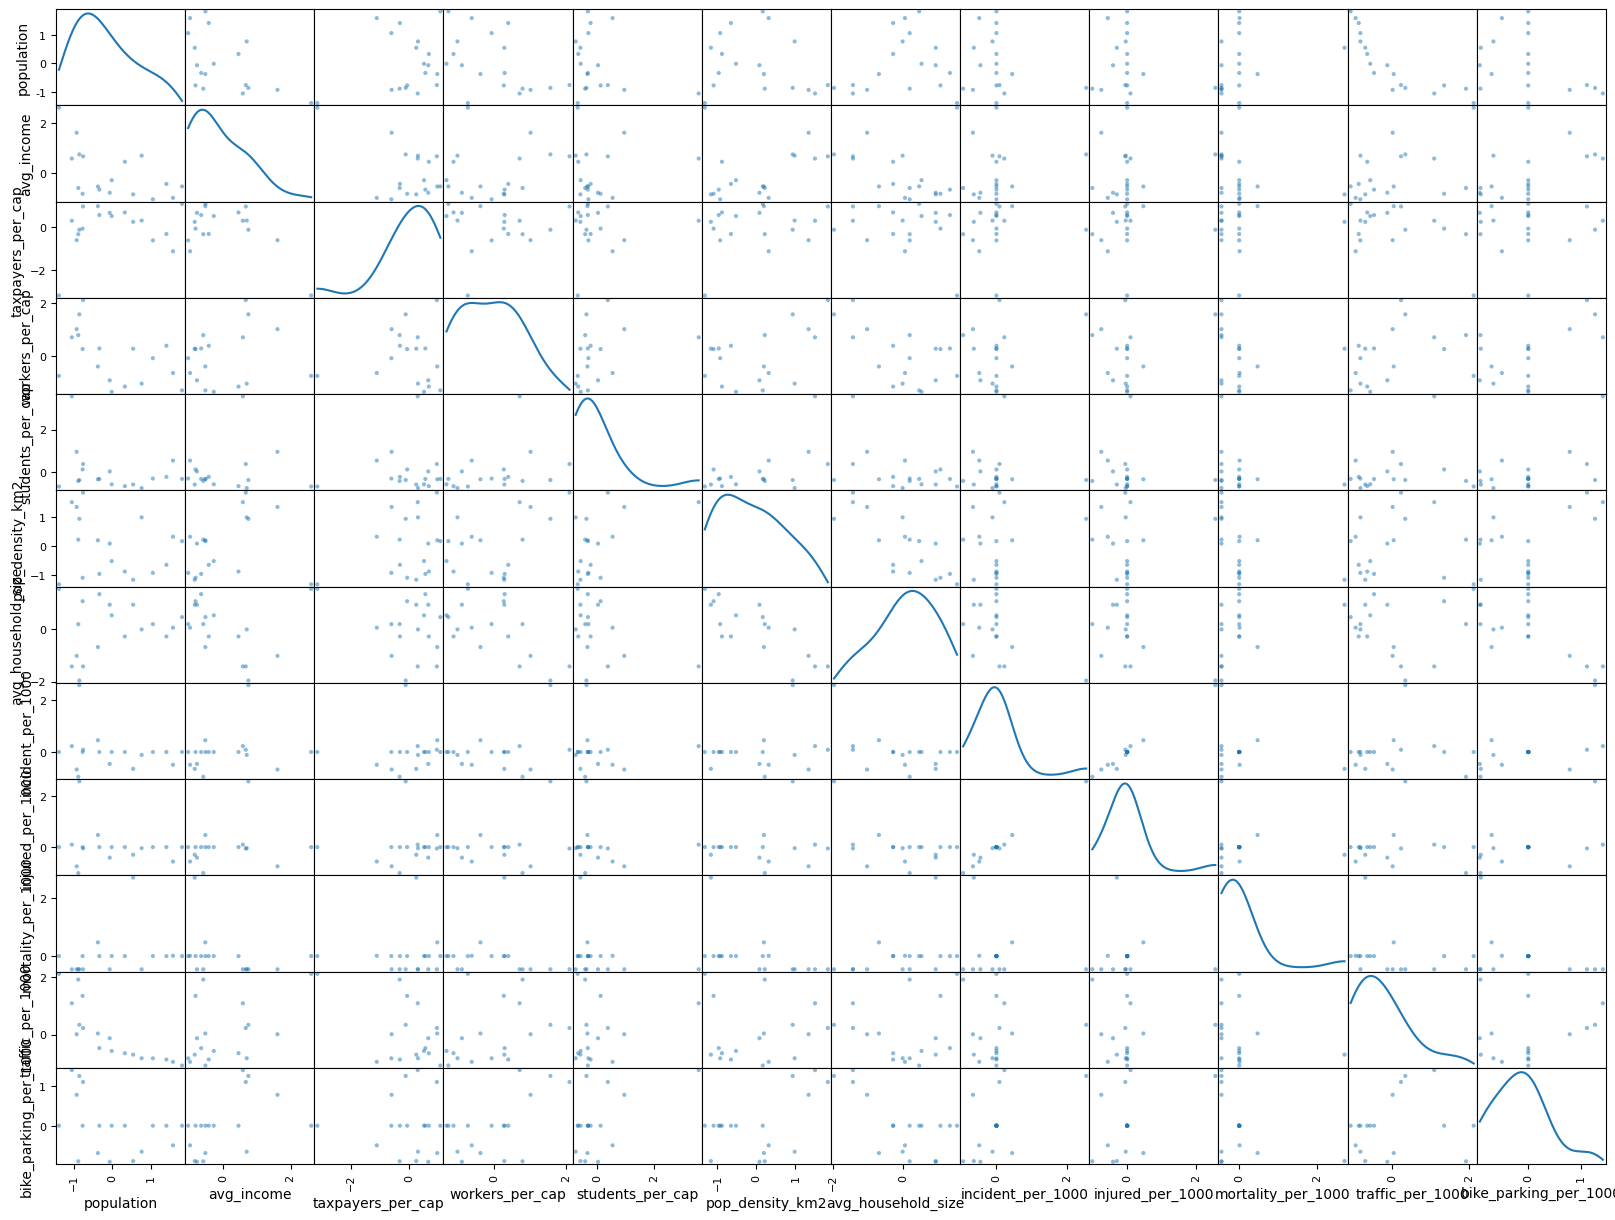

In [101]:
    # display matrix of correlation
    # *** interesting to note : seems like population size and bike parking seem to be the most singularly explantory variables of thise selected ?
pd.plotting.scatter_matrix(df_z.loc[:, 'population':'bike_parking_per_1000'], diagonal="kde",figsize=(20,15))
plt.show()
#df_z
#hinton(df_z.corr())
#df_z.corr()

Text(0, 0.5, 'SSE')

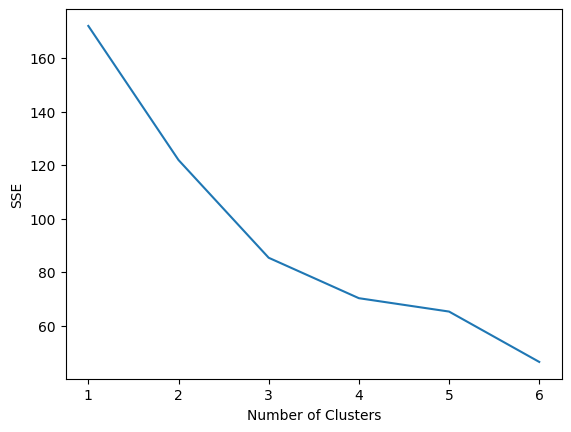

In [41]:
# test for best number of clusters - should use n-1 where n is the "elbow" of the plot where slope significantly changes
import matplotlib.pyplot as plt
%matplotlib inline

numClusters = [1,2,3,4,5,6]
SSE = []
for k in numClusters:
    k_means = cluster.KMeans(n_clusters=k)
    k_means.fit(df_z)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

In [42]:
# perform cluster analysis on df_z (all metrics) and display results
k_means = cluster.KMeans(n_clusters=3, max_iter=50, random_state=1)
k_means.fit(df_z) 
labels = k_means.labels_
clusters = pd.DataFrame(labels, index=df_z.index, columns=['Cluster ID'])
clusters

Cluster ID
zona                       
BARCA                     1
BOLOGNINA                 1
BORGO PANIGALE            1
COLLI                     2
CORTICELLA                1
COSTA SARAGOZZA           1
GALVANI                   0
IRNERIO                   0
LAME                      1
MALPIGHI                  0
MARCONI                   0
MAZZINI                   1
MURRI                     1
SAFFI                     1
SAN DONATO                1
SAN RUFFILLO              1
SAN VITALE                1
SANTA VIOLA               1

In [43]:
# perform cluster analysis on df_z_socioecon (socioecon metrics only) and display results
k_means_socioecon = cluster.KMeans(n_clusters=3, max_iter=50, random_state=1)
k_means_socioecon.fit(df_z_socioecon) 
labels_socioecon = k_means_socioecon.labels_
clusters_socioecon = pd.DataFrame(labels_socioecon, index=df_z_socioecon.index, columns=['Cluster ID'])
clusters_socioecon

Cluster ID
zona                       
BARCA                     1
BOLOGNINA                 1
BORGO PANIGALE            1
COLLI                     2
CORTICELLA                1
COSTA SARAGOZZA           1
GALVANI                   0
IRNERIO                   0
LAME                      1
MALPIGHI                  0
MARCONI                   0
MAZZINI                   1
MURRI                     1
SAFFI                     1
SAN DONATO                1
SAN RUFFILLO              1
SAN VITALE                1
SANTA VIOLA               1

In [44]:
# perform cluster analysis on df_z_transport (transport metrics only) and display results
k_means_transport = cluster.KMeans(n_clusters=3, max_iter=50, random_state=1)
k_means_transport.fit(df_z_transport) 
labels_transport = k_means_transport.labels_
clusters_transport = pd.DataFrame(labels, index=df_z_transport.index, columns=['Cluster ID'])
clusters_transport

Cluster ID
zona                       
BARCA                     1
BOLOGNINA                 1
BORGO PANIGALE            1
COLLI                     2
CORTICELLA                1
COSTA SARAGOZZA           1
GALVANI                   0
IRNERIO                   0
LAME                      1
MALPIGHI                  0
MARCONI                   0
MAZZINI                   1
MURRI                     1
SAFFI                     1
SAN DONATO                1
SAN RUFFILLO              1
SAN VITALE                1
SANTA VIOLA               1

In [45]:
# display characteristics of the clusters for all metrics
centroids = k_means.cluster_centers_
pd.DataFrame(centroids,columns=df_z.columns)

# results for df_z
# cluster 0 - central neighborhoods : 
    # lower population but higher density, richer, more students and workers, more traffic, more incidents, more bike parking
# cluster 1 - average outer neighborhoods
    # more population, slightly larger housholds (families), more taxpayers, less wealthy, lower traffic incidnets but higher mortality
# cluster 2 - colli
    # very rich, low density, larger households, more relative vehicle traffic probably due to high percentage of small population driving

population  avg_income  taxpayers_per_cap  workers_per_cap  \
0   -0.910244    0.906182           0.136311         1.349438   
1    0.387922   -0.479560           0.201534        -0.359064   
2   -1.402014    2.609549          -3.165192        -0.729920   

   students_per_cap  pop_density_km2  avg_household_size  incident_per_1000  \
0          1.129295         1.399040           -1.459000           0.549324   
1         -0.295084        -0.328852            0.331825          -0.169023   
2         -0.681091        -1.321078            1.522273           0.000000   

   injured_per_1000  mortality_per_1000  traffic_per_1000  \
0          0.464686           -0.455498          0.416596   
1         -0.142980            0.140153         -0.290865   
2          0.000000            0.000000          2.114862   

   bike_parking_per_1000  
0               1.138408  
1              -0.350279  
2               0.000000

In [46]:
# display characteristics of the clusters for the summary metrics
centroids_socioecon = k_means_socioecon.cluster_centers_
pd.DataFrame(centroids_socioecon,columns=df_z_socioecon.columns)

population  avg_income  taxpayers_per_cap  workers_per_cap  \
0   -0.910244    0.906182           0.136311         1.349438   
1    0.387922   -0.479560           0.201534        -0.359064   
2   -1.402014    2.609549          -3.165192        -0.729920   

   students_per_cap  pop_density_km2  avg_household_size  
0          1.129295         1.399040           -1.459000  
1         -0.295084        -0.328852            0.331825  
2         -0.681091        -1.321078            1.522273

In [47]:
# display characteristics of the clusters for the transport related metrics
centroids_transport = k_means_transport.cluster_centers_
pd.DataFrame(centroids_transport,columns=df_z_transport.columns)

incident_per_1000  injured_per_1000  mortality_per_1000  traffic_per_1000  \
0           2.554309          2.567720           -0.455498          0.338893   
1          -0.119412         -0.141741           -0.140682          0.022622   
2          -0.643725         -0.299860            2.706415         -0.700839   

   bike_parking_per_1000  
0               1.259160  
1              -0.022792  
2              -0.894484

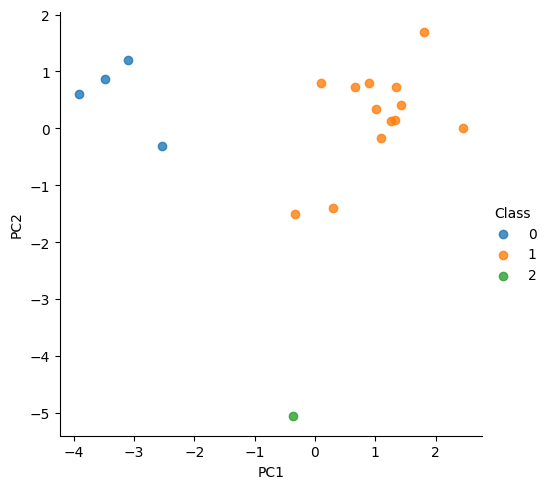

In [48]:
    # principal compoenents analysis
# set the resulting categories of the cluster analysis as dependent variable 
y = list(clusters['Cluster ID'])

# define the principal component analysis from the standardized z-score data
pca = PCA().fit(df_z)

# output the summary statistics for each principal component
#pca_summary(pca, df_z)

# display the coefficients for the first principal component
#pca.components_[0]

# display the screeplot to determine the number of principal components to retain
# should use n-1 where n is where the "elbow" of the plot occurs - where the slope significantly changes
#screeplot(pca, df_z) 
    # based on result - retain the first 3 principal components

# display a scatterplot of the data to show the clusters in comparison to the first two principal components
pca_scatter(pca, df_z, y)
# the PCA analysis and the cluster analysis appear compatible

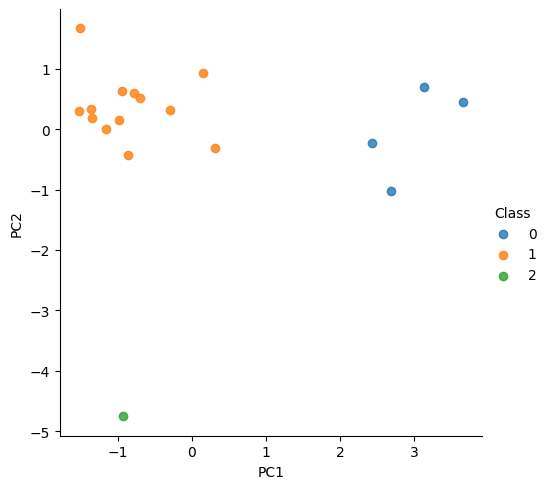

In [49]:
# repeat the analysis with the socioeconomic metrics
y_socioecon = list(clusters_socioecon['Cluster ID'])
pca_socioecon = PCA().fit(df_z_socioecon)
pca_scatter(pca_socioecon, df_z_socioecon, y_socioecon)

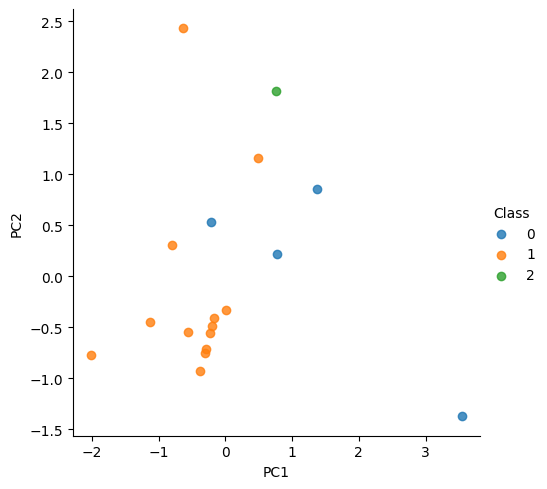

In [50]:
# repeat the analysis with the transport metrics
y_transport = list(clusters_transport['Cluster ID'])
pca_transport = PCA().fit(df_z_transport)
pca_scatter(pca_transport, df_z_transport, y_transport)

# current conclusion - the analysis of the combined dataset is being driven heavily by the summary statistics 
# removing the summary stats leads to a weak grouping from the transport related metrics
# to continue :
    # - try adding more metrics and see if that leads to a clearer explanation
    # - perform analysis using only transportation metrics WITHIN the clusters formed by the summary statistics
        # - maybe hierarchical analysis takes care of this?
    # - applying this clustering as a current state and using the first two principal components - look at how the 
        # members of the clusters have shifted up to this current point  - have these clusters been so well-defined in the past?
        # are the members of the cluster getting lcoser together, shifting farther apart, something else altogether?
        # create an animated graphic showing evolution of the cluster on these axes over time - by year

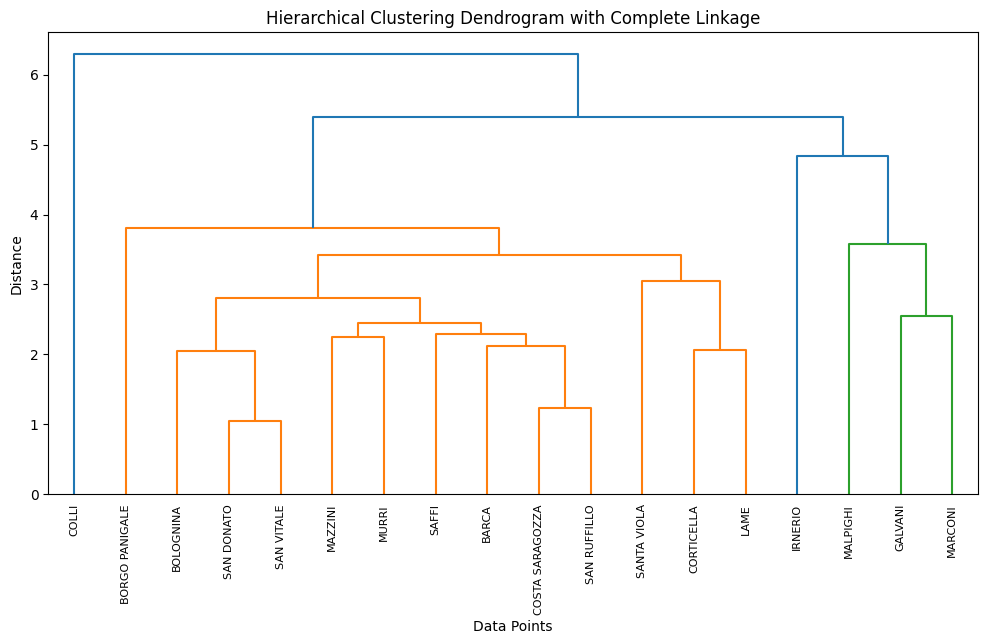

In [83]:
# hierarchical clustering - provides ability to see further granularity and inter-group similarities / differences compared to k-means

# average linkage - compares using average distance between members of each cluster
linkage_matrix = linkage(df_z, method='average', metric='euclidean')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=20, leaf_rotation=90., leaf_font_size=8., show_contracted=True, labels=df_z.index)
plt.title('Hierarchical Clustering Dendrogram with Complete Linkage')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

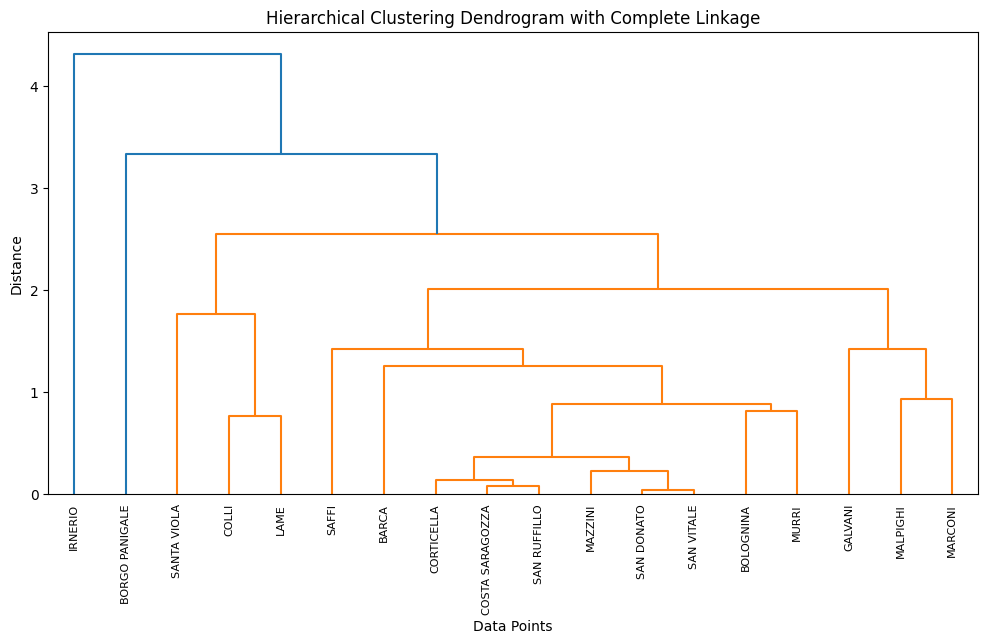

In [84]:
# repeat the hierarchical clustering from above but only with the transport related metrics
linkage_matrix = linkage(df_z_transport, method='average', metric='euclidean')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=20, leaf_rotation=90., leaf_font_size=8., show_contracted=True, labels=df_z_transport.index)
plt.title('Hierarchical Clustering Dendrogram with Complete Linkage')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()